In [1]:
import gc
import dill
import numpy as np
import pandas as pd
import axelrod as axl
from time import time
from pprint import pprint
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
pd.options.display.float_format = "{:,.2f}".format

# the following imports are from network / axl_utils folder
import network
from axl_utils.nnplayer import NNplayer, State
from axl_utils.game import *

In [2]:
C = axl.Action.C
D = axl.Action.D

# config game rules
# doubled game length for some extra complexity
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

### this stage will use axl.tournament function to let our DQN play against multiple strategies

Detailed documentation and more strategies can be found here: https://axelrod.readthedocs.io/en/stable/_modules/index.html

In [3]:
from axl_utils.tournament import Tournament

In [4]:
tournament = Tournament([axl.Defector(), axl.Cooperator()], game=GAME, turns=GAME_LEN)
results = tournament.play()

Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 124.37it/s]


In [5]:
# tournament result
# explanation of the elements can be found here: https://axelrod.readthedocs.io/en/stable/tutorials/advanced/tournament_results.html
summary = results.summarise()
headers = "Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate".split(',')
pd.DataFrame(map(list, summary), columns=headers)

# median score is based on normalized score, which represent the average return for each turn
# e.g. if 2 player cooperates the whole game, this should be 3.00 for both

,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,Defector,5.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0,0.00,0,0
1,1,Cooperator,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0,1.00,0,0


In [6]:
# to create a complex environment
# I'm trying to encourage provocative defection     (against cooperative strategies)
# and retaliative defection                         (against provocative)
# while at the same time punish excessive defection (against retaliative)

cooperative = (axl.Cooperator(), axl.TitFor2Tats())
provocative = (axl.Prober(), axl.Prober4(), axl.RemorsefulProber())
retaliative = (axl.TitForTat(), axl.Grudger(), axl.Punisher())
noise       = ()  #(axl.Random(), axl.Alternator())

players = [*cooperative, *provocative, *retaliative, *noise]
tournament = Tournament(players, game=GAME, turns=GAME_LEN)
results = tournament.play()

summary = results.summarise()
pd.DataFrame(map(list, summary), columns=headers)

Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 123.15it/s]


,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,Tit For Tat,2.83,0.89,0.00,1.00,0.80,0.09,0.08,0.02,1.00,0.00,1.00,0.00
1,1,Remorseful Prober: 0.1,2.59,0.67,3.00,1.00,0.54,0.12,0.15,0.18,0.90,0.00,0.88,0.54
2,2,Punisher,2.55,0.66,2.00,1.00,0.64,0.02,0.08,0.26,1.00,0.00,0.10,0.00
3,3,Grudger,2.54,0.66,2.00,1.00,0.64,0.02,0.08,0.26,1.00,0.00,0.00,0.00
4,4,Tit For 2 Tats,2.50,0.87,0.00,1.00,0.77,0.10,0.02,0.11,1.00,0.79,1.00,0.00
5,5,Prober,2.41,0.38,2.00,0.00,0.26,0.12,0.25,0.37,0.80,0.56,0.77,0.00
6,6,Prober 4,2.40,0.50,4.00,1.00,0.23,0.27,0.30,0.20,0.35,0.34,0.76,0.70
7,7,Cooperator,2.36,1.00,0.00,1.00,0.79,0.21,0.00,0.00,1.00,1.00,0.00,0.00


In [7]:
dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 300),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(300, 150),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(150, 80),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(80, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ],
            network.ReplayMemory(8000), gamma=0.9, greedy=0.2)
p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 1e-6, 'batch': 128, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l2', 1e-3), "loss_fn":"mse"}

In [8]:
from random import shuffle     

def train_against(trainee, trainers, iterations=40):
    shuffle(trainers)
    for trainer in trainers:
        for _  in range(iterations):
            play(trainee, trainer, show=False)

In [9]:
train_against(p1, players)
len(p1.network.memory)      # 21(turns) * 10(# of players) * 40(iterations)

6720

In [10]:
# time to take a nap
ls = []
loss_ls = []
epoch_ls = []
for i in range(100):
    
    start = time()
    p1.train(300, param, loss_targ=0.01)
    
    train_against(p1, players)
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # test DQN in tournament
    if i % 2 == 0:
        loss_ls.append(np.sum(p1.network.loss))
        with p1:
            p1.network.verbosity = False
            tournament = Tournament([p1, *players], game=GAME, turns=GAME_LEN)
            results = tournament.play()
            summary = pd.DataFrame(map(list, results.summarise()), columns=headers).set_index('Name')
            ls.append(summary)
            epoch_ls.append(p1.network.loss_ls[-1][0])
            
        print(summary.loc['DQN', ['Rank', 'Median_score']])
        
        # backing up
        with open('data/s2/tn_results.pkl', "wb") as file:
            dill.dump(ls, file)

        with open(f'data/s2/p1_{i}.pkl', "wb") as file:
            dill.dump(p1, file)

loss: [0.735 0.728],            time: +66.35 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 126.90it/s]


Rank           8.00
Median_score   1.95
Name: DQN, dtype: float64
loss: [0.691 0.689],            time: +85.23 sec
loss: [0.698 0.994],            time: +89.68 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 114.12it/s]


Rank           7.00
Median_score   2.27
Name: DQN, dtype: float64
loss: [0.861 0.937],            time: +89.65 sec
loss: [0.887 0.866],            time: +62.19 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 171.20it/s]


Rank           3.00
Median_score   2.51
Name: DQN, dtype: float64
loss: [0.93  0.909],            time: +68.36 sec
loss: [1.136 0.7  ],            time: +65.61 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 174.79it/s]


Rank           4.00
Median_score   2.50
Name: DQN, dtype: float64
loss: [1.027 0.833],            time: +66.64 sec
loss: [1.22  0.962],            time: +65.92 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 165.53it/s]


Rank           4.00
Median_score   2.49
Name: DQN, dtype: float64
loss: [1.405 0.82 ],            time: +69.34 sec
loss: [1.298 0.817],            time: +67.60 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 152.41it/s]


Rank           1.00
Median_score   2.56
Name: DQN, dtype: float64
loss: [1.395 0.937],            time: +67.79 sec
loss: [1.662 0.99 ],            time: +63.72 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 174.79it/s]


Rank           1.00
Median_score   2.58
Name: DQN, dtype: float64
loss: [1.138 1.013],            time: +68.23 sec
loss: [1.215 0.988],            time: +63.60 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 168.92it/s]


Rank           1.00
Median_score   2.56
Name: DQN, dtype: float64
loss: [1.138 0.978],            time: +112.46 sec
loss: [0.987 0.95 ],            time: +139.42 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 163.37it/s]


Rank           4.00
Median_score   2.53
Name: DQN, dtype: float64
loss: [0.972 0.953],            time: +117.84 sec
loss: [1.537 0.93 ],            time: +72.15 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 170.04it/s]


Rank           1.00
Median_score   2.69
Name: DQN, dtype: float64
loss: [0.873 0.964],            time: +92.73 sec
loss: [1.217 0.982],            time: +147.05 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 128.20it/s]


Rank           1.00
Median_score   2.68
Name: DQN, dtype: float64
loss: [1.083 0.912],            time: +87.10 sec
loss: [0.998 0.953],            time: +101.93 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 111.19it/s]


Rank           1.00
Median_score   2.70
Name: DQN, dtype: float64
loss: [1.122 0.916],            time: +93.54 sec
loss: [1.116 0.995],            time: +112.51 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 122.55it/s]


Rank           1.00
Median_score   2.67
Name: DQN, dtype: float64
loss: [1.317 0.97 ],            time: +79.52 sec
loss: [0.899 0.886],            time: +146.95 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 158.18it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [1.23  0.957],            time: +93.33 sec
loss: [1.111 0.948],            time: +66.02 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 142.02it/s]


Rank           1.00
Median_score   2.69
Name: DQN, dtype: float64
loss: [1.197 1.088],            time: +63.44 sec
loss: [1.111 1.062],            time: +103.07 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 172.38it/s]


Rank           1.00
Median_score   2.61
Name: DQN, dtype: float64
loss: [1.308 1.085],            time: +64.60 sec
loss: [1.367 1.127],            time: +74.69 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 163.37it/s]


Rank           1.00
Median_score   2.67
Name: DQN, dtype: float64
loss: [1.189 0.871],            time: +79.45 sec
loss: [1.178 1.055],            time: +99.62 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 174.82it/s]


Rank           1.00
Median_score   2.72
Name: DQN, dtype: float64
loss: [1.134 1.01 ],            time: +91.76 sec
loss: [1.109 0.799],            time: +76.29 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 170.07it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [0.948 0.849],            time: +120.90 sec
loss: [1.137 0.814],            time: +88.99 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 143.47it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [1.158 0.759],            time: +126.85 sec
loss: [0.948 0.864],            time: +85.69 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 162.31it/s]


Rank           1.00
Median_score   2.72
Name: DQN, dtype: float64
loss: [1.168 1.045],            time: +74.62 sec
loss: [1.065 0.965],            time: +144.09 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 168.92it/s]


Rank           1.00
Median_score   2.69
Name: DQN, dtype: float64
loss: [1.092 0.977],            time: +98.45 sec
loss: [1.18 0.82],            time: +92.75 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 136.59it/s]


Rank           1.00
Median_score   2.76
Name: DQN, dtype: float64
loss: [0.937 0.894],            time: +115.50 sec
loss: [1.166 0.712],            time: +72.03 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 160.25it/s]


Rank           0.00
Median_score   2.98
Name: DQN, dtype: float64
loss: [0.777 0.697],            time: +70.50 sec
loss: [1.054 0.918],            time: +76.41 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 155.29it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [1.192 0.707],            time: +87.77 sec
loss: [1.509 0.641],            time: +68.49 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 170.03it/s]


Rank           1.00
Median_score   2.71
Name: DQN, dtype: float64
loss: [0.92  1.347],            time: +62.95 sec
loss: [0.842 1.272],            time: +76.21 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 185.16it/s]


Rank           1.00
Median_score   2.71
Name: DQN, dtype: float64
loss: [1.22  0.696],            time: +71.30 sec
loss: [1.377 0.887],            time: +102.64 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 179.86it/s]


Rank           1.00
Median_score   2.70
Name: DQN, dtype: float64
loss: [1.236 0.539],            time: +180.13 sec
loss: [1.43  0.626],            time: +100.59 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 178.58it/s]


Rank           1.00
Median_score   2.67
Name: DQN, dtype: float64
loss: [1.115 0.861],            time: +90.93 sec
loss: [1.401 0.814],            time: +69.26 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 183.73it/s]


Rank           1.00
Median_score   2.73
Name: DQN, dtype: float64
loss: [1.359 0.428],            time: +99.46 sec
loss: [1.128 0.783],            time: +110.19 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 179.86it/s]


Rank           1.00
Median_score   2.73
Name: DQN, dtype: float64
loss: [1.135 0.924],            time: +81.44 sec
loss: [1.311 0.756],            time: +81.73 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 173.57it/s]


Rank           1.00
Median_score   2.72
Name: DQN, dtype: float64
loss: [1.083 0.732],            time: +62.61 sec
loss: [1.057 1.032],            time: +98.32 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 171.18it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [0.888 0.928],            time: +89.19 sec
loss: [1.387 0.875],            time: +165.27 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 167.78it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [0.978 1.128],            time: +89.63 sec
loss: [1.194 0.697],            time: +65.71 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 164.44it/s]


Rank           1.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [1.12 0.96],            time: +68.61 sec
loss: [0.801 1.129],            time: +125.76 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 172.41it/s]


Rank           0.00
Median_score   2.82
Name: DQN, dtype: float64
loss: [1.17  0.722],            time: +85.27 sec
loss: [1.089 1.065],            time: +112.53 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 182.44it/s]


Rank           1.00
Median_score   2.82
Name: DQN, dtype: float64
loss: [1.188 1.102],            time: +70.85 sec
loss: [1.19  0.969],            time: +155.75 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 182.44it/s]


Rank           1.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [1.429 0.751],            time: +73.72 sec
loss: [0.953 0.937],            time: +84.21 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 179.81it/s]


Rank           0.00
Median_score   2.84
Name: DQN, dtype: float64
loss: [1.309 0.569],            time: +62.97 sec
loss: [1.042 0.475],            time: +179.98 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 172.37it/s]


Rank           1.00
Median_score   2.62
Name: DQN, dtype: float64
loss: [0.99 1.02],            time: +65.45 sec
loss: [1.184 0.714],            time: +87.12 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 171.24it/s]


Rank           0.00
Median_score   2.98
Name: DQN, dtype: float64
loss: [0.947 0.64 ],            time: +63.08 sec
loss: [0.729 1.245],            time: +75.43 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 167.75it/s]


Rank           1.00
Median_score   2.68
Name: DQN, dtype: float64
loss: [1.162 0.96 ],            time: +64.58 sec
loss: [1.003 1.023],            time: +69.04 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 171.94it/s]


Rank           0.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [1.037 1.017],            time: +113.01 sec
loss: [1.043 1.151],            time: +74.75 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.63it/s]


Rank           1.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [1.25  0.538],            time: +68.78 sec
loss: [1.034 0.813],            time: +70.80 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 177.31it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [1.064 0.834],            time: +66.28 sec
loss: [1.002 1.11 ],            time: +62.68 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 167.79it/s]


Rank           1.00
Median_score   2.76
Name: DQN, dtype: float64
loss: [1.091 0.677],            time: +81.70 sec
loss: [0.8   0.922],            time: +71.40 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 172.42it/s]


Rank           0.00
Median_score   2.81
Name: DQN, dtype: float64
loss: [0.71  0.992],            time: +84.41 sec
loss: [0.875 1.175],            time: +62.67 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 170.04it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [1.27  0.644],            time: +75.57 sec
loss: [0.783 1.266],            time: +113.63 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 182.44it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [0.768 1.389],            time: +77.98 sec
loss: [1.51  0.782],            time: +84.48 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 181.12it/s]


Rank           0.00
Median_score   2.91
Name: DQN, dtype: float64
loss: [1.062 0.942],            time: +83.40 sec


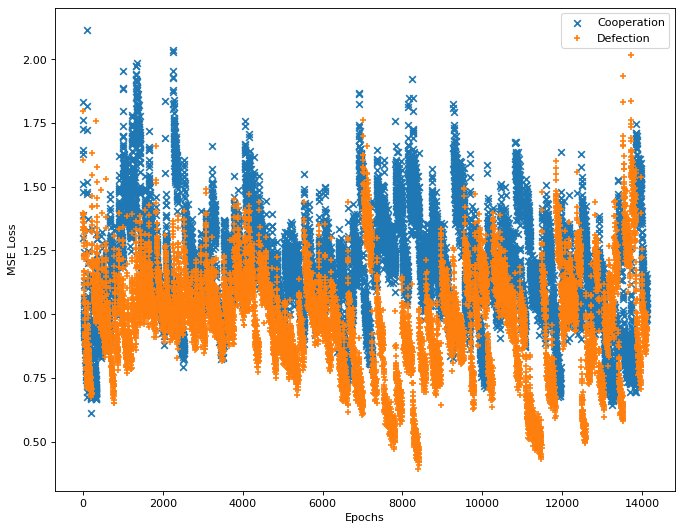

In [11]:
p1.plot()

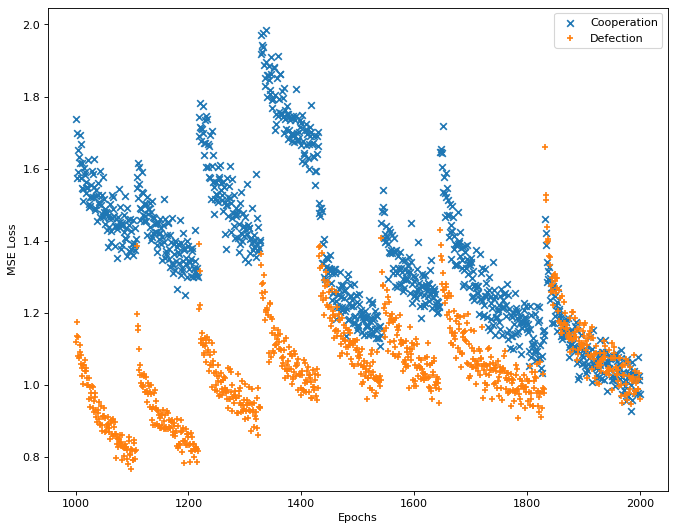

In [12]:
p1.plot(min_ran=1000,max_ran=2000)

In [13]:
pd.DataFrame([l.loc['DQN'] for l in ls])

,Rank,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
DQN,8.00,1.95,0.00,8.00,0.00,0.00,0.00,0.24,0.76,0.00,0.00,0.00,0.00
DQN,7.00,2.27,0.50,3.00,0.00,0.09,0.40,0.37,0.13,0.35,0.46,0.75,0.73
DQN,3.00,2.51,0.39,6.00,0.00,0.07,0.32,0.42,0.19,0.08,0.32,0.64,0.56
DQN,4.00,2.50,0.61,4.00,1.00,0.34,0.26,0.27,0.13,0.64,0.29,0.92,0.62
DQN,4.00,2.49,0.43,5.00,1.00,0.16,0.26,0.36,0.21,0.33,0.30,0.74,0.69
DQN,1.00,2.56,0.39,4.00,0.00,0.12,0.28,0.40,0.21,0.51,0.27,0.66,0.69
DQN,1.00,2.58,0.51,4.00,1.00,0.30,0.21,0.30,0.19,0.63,0.44,0.56,0.74
DQN,1.00,2.56,0.43,4.00,0.00,0.20,0.23,0.35,0.22,0.84,0.21,0.81,0.59
DQN,4.00,2.53,0.47,3.00,1.00,0.21,0.26,0.34,0.18,0.44,0.22,0.80,0.65
DQN,1.00,2.69,0.64,4.00,1.00,0.45,0.20,0.25,0.11,0.82,0.52,0.65,0.87


In [14]:
things = ['Rank', 'Median_score', 'Cooperation_rating', 'Initial_C_rate', 'CC_to_C_rate', 'CD_to_C_rate']
pd.DataFrame([[l.loc['DQN',t] for t in things] for l in ls], columns=things)

,Rank,Median_score,Cooperation_rating,Initial_C_rate,CC_to_C_rate,CD_to_C_rate
0,8,1.95,0.00,0.00,0.00,0.00
1,7,2.27,0.50,0.00,0.35,0.46
2,3,2.51,0.39,0.00,0.08,0.32
3,4,2.50,0.61,1.00,0.64,0.29
4,4,2.49,0.43,1.00,0.33,0.30
5,1,2.56,0.39,0.00,0.51,0.27
6,1,2.58,0.51,1.00,0.63,0.44
7,1,2.56,0.43,0.00,0.84,0.21
8,4,2.53,0.47,1.00,0.44,0.22
9,1,2.69,0.64,1.00,0.82,0.52


In [15]:
a = pd.DataFrame([l.loc['DQN','Median_score'] for l in ls]).to_numpy().T[0]
b = pd.DataFrame([l.loc['Tit For Tat','Median_score'] for l in ls]).to_numpy().T[0]

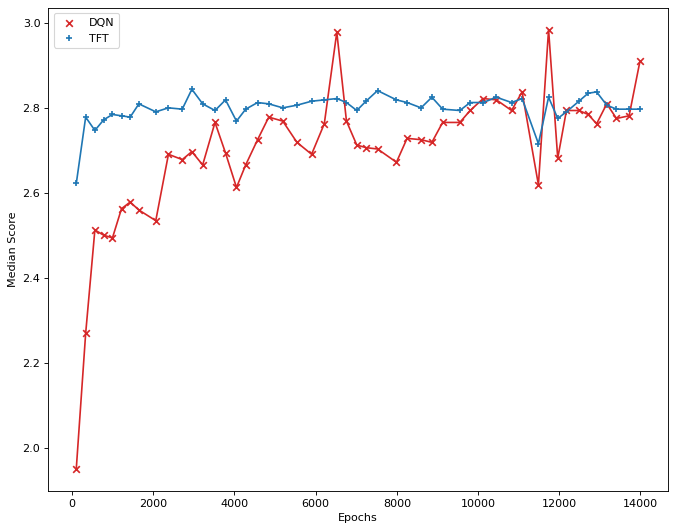

In [19]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(epoch_ls, a, c='tab:red', marker='x', label='DQN')
plt.scatter(epoch_ls, b, c='tab:blue', marker='+', label='TFT')
plt.plot(epoch_ls, a, c='tab:red')
plt.plot(epoch_ls, b, c='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Median Score')
plt.legend(loc='upper left')
plt.show()

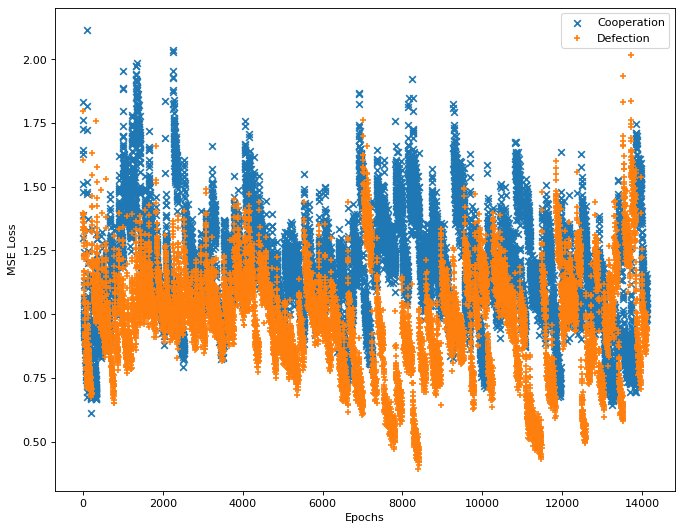

In [20]:
p1.plot()